In [105]:
import pandas as pd
import numpy as np
import math
import os

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing imports
import cv2
from PIL import Image
from PIL import ImageStat
from colorthief import ColorThief
from colormap import rgb2hex
from IPython.display import Markdown, display
import colorsys

# Sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Concatenating pictures

In [87]:
X_train = pd.read_csv("../raw_data/train_x.csv", delimiter=" ", index_col="Id")
y_train = pd.read_csv("../raw_data/train_y.csv", delimiter=" ", index_col="Id")

In [88]:
X_train.head()

,Image_name,Title
Id,,
0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear
1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz..."
2,1446276082.jpg,Energy Security (SAGE Library of International...
3,1491522666.jpg,An Amish Gathering: Life in Lancaster County
4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...


In [89]:
y_train.head()

,Genre_id,Genre_name
Id,,
0,1,Biographies & Memoirs
1,4,Children's Books
2,10,Engineering & Transportation
3,9,Christian Books & Bibles
4,26,Sports & Outdoors


In [90]:
df_train = X_train.merge(y_train, how='inner', on='Id')

In [91]:
df_train.head()

,Image_name,Title,Genre_id,Genre_name
Id,,,,
0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,1,Biographies & Memoirs
1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",4,Children's Books
2,1446276082.jpg,Energy Security (SAGE Library of International...,10,Engineering & Transportation
3,1491522666.jpg,An Amish Gathering: Life in Lancaster County,9,Christian Books & Bibles
4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...,26,Sports & Outdoors


In [140]:
genre_dict = df_train.set_index('Genre_id')['Genre_name'].to_dict()

In [141]:
genre_dict

{1: 'Biographies & Memoirs',
 4: "Children's Books",
 10: 'Engineering & Transportation',
 9: 'Christian Books & Bibles',
 26: 'Sports & Outdoors',
 11: 'Health, Fitness & Dieting',
 16: 'Medical Books',
 23: 'Science & Math',
 29: 'Travel',
 2: 'Business & Money',
 7: 'Cookbooks, Food & Wine',
 19: 'Politics & Social Sciences',
 8: 'Crafts, Hobbies & Home',
 21: 'Religion & Spirituality',
 15: 'Literature & Fiction',
 13: 'Humor & Entertainment',
 14: 'Law',
 6: 'Computers & Technology',
 28: 'Test Preparation',
 0: 'Arts & Photography',
 18: 'Parenting & Relationships',
 22: 'Romance',
 12: 'History',
 5: 'Comics & Graphic Novels',
 20: 'Reference',
 27: 'Teen & Young Adult',
 25: 'Self-Help',
 3: 'Calendars',
 24: 'Science Fiction & Fantasy',
 17: 'Mystery, Thriller & Suspense'}

In [65]:
for categ in df_train.Genre_id.unique():
    
    # Creating a temporary dataframe
    df_temp = df_train[df_train['Genre_id'] == categ]
    
    # Splitting it in 45 equal chunks to have a 'big picture' of 45 x 38 pictures (=1710 images per category)
    df_temp_ls = np.split(df_temp, 45)
    
    # Creating pictures of 38 pictures vertically stacked
    for v in range(45):
        img_to_v_concat = []
        for image_name in df_temp_ls[v]['Image_name']:
            image_path = os.path.join("../raw_data/Images/", image_name)
            img_temp = cv2.imread(image_path)
            img_to_v_concat.append(img_temp)
        
        img_concat_v = cv2.vconcat(img_to_v_concat)
        val = cv2.imwrite(f"../raw_data/Images_concat_temp/{categ}_{v}.jpg", img_concat_v)
        if val == False:
            print("Image is not saved on the disk.")
    
    # Creating a picture of 45 pictures (of 38 pictures each) horizontally stacked (our 'big picture')
    img_to_h_concat = []
    for h in range(45):
        image_path = f"../raw_data/Images_concat_temp/{categ}_{h}.jpg"
        img_temp = cv2.imread(image_path)
        img_to_h_concat.append(img_temp)

    img_concat = cv2.hconcat(img_to_h_concat)
    val = cv2.imwrite(f"../raw_data/Images_concat/{categ}.jpg", img_concat)
    if val == False:
        print("Image is not saved on the disk.")

# Extracting main colors (palettes) per category

In [109]:
for i in range(30):
    print(f"Color palette for genre {genre_dict[i]}")
    color_thief = ColorThief(f"../raw_data/Images_concat/{i}.jpg")
    palette = color_thief.get_palette(color_count=10)
    palette_hex = [rgb2hex(int(i[0]), int(i[1]), int(i[2])) for i in palette]
    display(Markdown('<br>'.join(
        f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
        for color in palette_hex
    )))
    print("")

Color palette for genre Arts & Photography


<span style="font-family: monospace">#1C242A <span style="color: #1C242A">████████</span></span><br><span style="font-family: monospace">#D9D4CB <span style="color: #D9D4CB">████████</span></span><br><span style="font-family: monospace">#7A3132 <span style="color: #7A3132">████████</span></span><br><span style="font-family: monospace">#5F6D73 <span style="color: #5F6D73">████████</span></span><br><span style="font-family: monospace">#9E7732 <span style="color: #9E7732">████████</span></span><br><span style="font-family: monospace">#9C6E68 <span style="color: #9C6E68">████████</span></span><br><span style="font-family: monospace">#B9A069 <span style="color: #B9A069">████████</span></span><br><span style="font-family: monospace">#8F9DA3 <span style="color: #8F9DA3">████████</span></span><br><span style="font-family: monospace">#20A3A7 <span style="color: #20A3A7">████████</span></span>


Color palette for genre Biographies & Memoirs


<span style="font-family: monospace">#1C1F24 <span style="color: #1C1F24">████████</span></span><br><span style="font-family: monospace">#DED7CB <span style="color: #DED7CB">████████</span></span><br><span style="font-family: monospace">#792F2C <span style="color: #792F2C">████████</span></span><br><span style="font-family: monospace">#646E72 <span style="color: #646E72">████████</span></span><br><span style="font-family: monospace">#9B6F33 <span style="color: #9B6F33">████████</span></span><br><span style="font-family: monospace">#BD9F6A <span style="color: #BD9F6A">████████</span></span><br><span style="font-family: monospace">#A26E61 <span style="color: #A26E61">████████</span></span><br><span style="font-family: monospace">#959FA1 <span style="color: #959FA1">████████</span></span><br><span style="font-family: monospace">#1FA6AC <span style="color: #1FA6AC">████████</span></span>


Color palette for genre Business & Money


<span style="font-family: monospace">#D8DAD5 <span style="color: #D8DAD5">████████</span></span><br><span style="font-family: monospace">#863035 <span style="color: #863035">████████</span></span><br><span style="font-family: monospace">#192933 <span style="color: #192933">████████</span></span><br><span style="font-family: monospace">#BC962F <span style="color: #BC962F">████████</span></span><br><span style="font-family: monospace">#617D8A <span style="color: #617D8A">████████</span></span><br><span style="font-family: monospace">#A27C76 <span style="color: #A27C76">████████</span></span><br><span style="font-family: monospace">#C7B575 <span style="color: #C7B575">████████</span></span><br><span style="font-family: monospace">#1A6AB1 <span style="color: #1A6AB1">████████</span></span><br><span style="font-family: monospace">#18AAB4 <span style="color: #18AAB4">████████</span></span>


Color palette for genre Calendars


<span style="font-family: monospace">#1F292F <span style="color: #1F292F">████████</span></span><br><span style="font-family: monospace">#D8D0C4 <span style="color: #D8D0C4">████████</span></span><br><span style="font-family: monospace">#7C2F2F <span style="color: #7C2F2F">████████</span></span><br><span style="font-family: monospace">#967932 <span style="color: #967932">████████</span></span><br><span style="font-family: monospace">#5F747E <span style="color: #5F747E">████████</span></span><br><span style="font-family: monospace">#9E6D68 <span style="color: #9E6D68">████████</span></span><br><span style="font-family: monospace">#B9A362 <span style="color: #B9A362">████████</span></span><br><span style="font-family: monospace">#8EA0A9 <span style="color: #8EA0A9">████████</span></span><br><span style="font-family: monospace">#1FA6BA <span style="color: #1FA6BA">████████</span></span>


Color palette for genre Children's Books


<span style="font-family: monospace">#24343E <span style="color: #24343E">████████</span></span><br><span style="font-family: monospace">#883435 <span style="color: #883435">████████</span></span><br><span style="font-family: monospace">#D6DAD5 <span style="color: #D6DAD5">████████</span></span><br><span style="font-family: monospace">#B38E2F <span style="color: #B38E2F">████████</span></span><br><span style="font-family: monospace">#668187 <span style="color: #668187">████████</span></span><br><span style="font-family: monospace">#BC9A60 <span style="color: #BC9A60">████████</span></span><br><span style="font-family: monospace">#C7B88D <span style="color: #C7B88D">████████</span></span><br><span style="font-family: monospace">#A37D92 <span style="color: #A37D92">████████</span></span><br><span style="font-family: monospace">#21AFBB <span style="color: #21AFBB">████████</span></span>


Color palette for genre Comics & Graphic Novels


<span style="font-family: monospace">#1D2227 <span style="color: #1D2227">████████</span></span><br><span style="font-family: monospace">#7D2F31 <span style="color: #7D2F31">████████</span></span><br><span style="font-family: monospace">#E4D9CC <span style="color: #E4D9CC">████████</span></span><br><span style="font-family: monospace">#647378 <span style="color: #647378">████████</span></span><br><span style="font-family: monospace">#A87D30 <span style="color: #A87D30">████████</span></span><br><span style="font-family: monospace">#A96B6A <span style="color: #A96B6A">████████</span></span><br><span style="font-family: monospace">#C4A868 <span style="color: #C4A868">████████</span></span><br><span style="font-family: monospace">#9AA5A8 <span style="color: #9AA5A8">████████</span></span><br><span style="font-family: monospace">#1BA6AB <span style="color: #1BA6AB">████████</span></span>


Color palette for genre Computers & Technology


<span style="font-family: monospace">#8FBFA4 <span style="color: #8FBFA4">████████</span></span><br><span style="font-family: monospace">#232223 <span style="color: #232223">████████</span></span><br><span style="font-family: monospace">#E9E4D7 <span style="color: #E9E4D7">████████</span></span><br><span style="font-family: monospace">#467FB7 <span style="color: #467FB7">████████</span></span><br><span style="font-family: monospace">#986357 <span style="color: #986357">████████</span></span><br><span style="font-family: monospace">#EBBD2F <span style="color: #EBBD2F">████████</span></span><br><span style="font-family: monospace">#DF3932 <span style="color: #DF3932">████████</span></span><br><span style="font-family: monospace">#487D6D <span style="color: #487D6D">████████</span></span><br><span style="font-family: monospace">#2F4C7A <span style="color: #2F4C7A">████████</span></span>


Color palette for genre Cookbooks, Food & Wine


<span style="font-family: monospace">#282B2A <span style="color: #282B2A">████████</span></span><br><span style="font-family: monospace">#8A322D <span style="color: #8A322D">████████</span></span><br><span style="font-family: monospace">#E1DED5 <span style="color: #E1DED5">████████</span></span><br><span style="font-family: monospace">#A7895F <span style="color: #A7895F">████████</span></span><br><span style="font-family: monospace">#AF7F30 <span style="color: #AF7F30">████████</span></span><br><span style="font-family: monospace">#7893A1 <span style="color: #7893A1">████████</span></span><br><span style="font-family: monospace">#CBB58D <span style="color: #CBB58D">████████</span></span><br><span style="font-family: monospace">#29A694 <span style="color: #29A694">████████</span></span><br><span style="font-family: monospace">#B5808B <span style="color: #B5808B">████████</span></span>


Color palette for genre Crafts, Hobbies & Home


<span style="font-family: monospace">#222D2E <span style="color: #222D2E">████████</span></span><br><span style="font-family: monospace">#823435 <span style="color: #823435">████████</span></span><br><span style="font-family: monospace">#DBD9D3 <span style="color: #DBD9D3">████████</span></span><br><span style="font-family: monospace">#677775 <span style="color: #677775">████████</span></span><br><span style="font-family: monospace">#9D7E32 <span style="color: #9D7E32">████████</span></span><br><span style="font-family: monospace">#B28E61 <span style="color: #B28E61">████████</span></span><br><span style="font-family: monospace">#C0B08E <span style="color: #C0B08E">████████</span></span><br><span style="font-family: monospace">#A4808F <span style="color: #A4808F">████████</span></span><br><span style="font-family: monospace">#24B1A7 <span style="color: #24B1A7">████████</span></span>


Color palette for genre Christian Books & Bibles


<span style="font-family: monospace">#1E2731 <span style="color: #1E2731">████████</span></span><br><span style="font-family: monospace">#732C2E <span style="color: #732C2E">████████</span></span><br><span style="font-family: monospace">#E4DCCC <span style="color: #E4DCCC">████████</span></span><br><span style="font-family: monospace">#A07632 <span style="color: #A07632">████████</span></span><br><span style="font-family: monospace">#63737B <span style="color: #63737B">████████</span></span><br><span style="font-family: monospace">#A47265 <span style="color: #A47265">████████</span></span><br><span style="font-family: monospace">#C7AA68 <span style="color: #C7AA68">████████</span></span><br><span style="font-family: monospace">#9AA8AB <span style="color: #9AA8AB">████████</span></span><br><span style="font-family: monospace">#1FAABB <span style="color: #1FAABB">████████</span></span>


Color palette for genre Engineering & Transportation


<span style="font-family: monospace">#E3D5B8 <span style="color: #E3D5B8">████████</span></span><br><span style="font-family: monospace">#202528 <span style="color: #202528">████████</span></span><br><span style="font-family: monospace">#92BBBB <span style="color: #92BBBB">████████</span></span><br><span style="font-family: monospace">#937268 <span style="color: #937268">████████</span></span><br><span style="font-family: monospace">#5589BF <span style="color: #5589BF">████████</span></span><br><span style="font-family: monospace">#D93833 <span style="color: #D93833">████████</span></span><br><span style="font-family: monospace">#53807C <span style="color: #53807C">████████</span></span><br><span style="font-family: monospace">#325387 <span style="color: #325387">████████</span></span><br><span style="font-family: monospace">#614D46 <span style="color: #614D46">████████</span></span>


Color palette for genre Health, Fitness & Dieting


<span style="font-family: monospace">#223242 <span style="color: #223242">████████</span></span><br><span style="font-family: monospace">#953439 <span style="color: #953439">████████</span></span><br><span style="font-family: monospace">#E3E3E0 <span style="color: #E3E3E0">████████</span></span><br><span style="font-family: monospace">#728B94 <span style="color: #728B94">████████</span></span><br><span style="font-family: monospace">#BE9832 <span style="color: #BE9832">████████</span></span><br><span style="font-family: monospace">#C8A26D <span style="color: #C8A26D">████████</span></span><br><span style="font-family: monospace">#D0C09D <span style="color: #D0C09D">████████</span></span><br><span style="font-family: monospace">#25ABAF <span style="color: #25ABAF">████████</span></span><br><span style="font-family: monospace">#B6889F <span style="color: #B6889F">████████</span></span>


Color palette for genre History


<span style="font-family: monospace">#1D252A <span style="color: #1D252A">████████</span></span><br><span style="font-family: monospace">#D9D2C4 <span style="color: #D9D2C4">████████</span></span><br><span style="font-family: monospace">#7A2F2D <span style="color: #7A2F2D">████████</span></span><br><span style="font-family: monospace">#9A6F32 <span style="color: #9A6F32">████████</span></span><br><span style="font-family: monospace">#5F6C73 <span style="color: #5F6C73">████████</span></span><br><span style="font-family: monospace">#976F63 <span style="color: #976F63">████████</span></span><br><span style="font-family: monospace">#B99F64 <span style="color: #B99F64">████████</span></span><br><span style="font-family: monospace">#8E9B9F <span style="color: #8E9B9F">████████</span></span><br><span style="font-family: monospace">#1BA6B0 <span style="color: #1BA6B0">████████</span></span>


Color palette for genre Humor & Entertainment


<span style="font-family: monospace">#1C242A <span style="color: #1C242A">████████</span></span><br><span style="font-family: monospace">#863234 <span style="color: #863234">████████</span></span><br><span style="font-family: monospace">#E3DDD1 <span style="color: #E3DDD1">████████</span></span><br><span style="font-family: monospace">#B79132 <span style="color: #B79132">████████</span></span><br><span style="font-family: monospace">#647D85 <span style="color: #647D85">████████</span></span><br><span style="font-family: monospace">#AB7475 <span style="color: #AB7475">████████</span></span><br><span style="font-family: monospace">#C8B06E <span style="color: #C8B06E">████████</span></span><br><span style="font-family: monospace">#9BACB2 <span style="color: #9BACB2">████████</span></span><br><span style="font-family: monospace">#1CA5AD <span style="color: #1CA5AD">████████</span></span>


Color palette for genre Law


<span style="font-family: monospace">#E3D4B9 <span style="color: #E3D4B9">████████</span></span><br><span style="font-family: monospace">#20272B <span style="color: #20272B">████████</span></span><br><span style="font-family: monospace">#8EBDB3 <span style="color: #8EBDB3">████████</span></span><br><span style="font-family: monospace">#956155 <span style="color: #956155">████████</span></span><br><span style="font-family: monospace">#5881B9 <span style="color: #5881B9">████████</span></span><br><span style="font-family: monospace">#CF3133 <span style="color: #CF3133">████████</span></span><br><span style="font-family: monospace">#2F4E7E <span style="color: #2F4E7E">████████</span></span><br><span style="font-family: monospace">#4D8170 <span style="color: #4D8170">████████</span></span><br><span style="font-family: monospace">#61423A <span style="color: #61423A">████████</span></span>


Color palette for genre Literature & Fiction


<span style="font-family: monospace">#1D252A <span style="color: #1D252A">████████</span></span><br><span style="font-family: monospace">#7F2E2D <span style="color: #7F2E2D">████████</span></span><br><span style="font-family: monospace">#DFD8C9 <span style="color: #DFD8C9">████████</span></span><br><span style="font-family: monospace">#A57D31 <span style="color: #A57D31">████████</span></span><br><span style="font-family: monospace">#63797D <span style="color: #63797D">████████</span></span><br><span style="font-family: monospace">#C3A867 <span style="color: #C3A867">████████</span></span><br><span style="font-family: monospace">#A86D67 <span style="color: #A86D67">████████</span></span><br><span style="font-family: monospace">#96A5A8 <span style="color: #96A5A8">████████</span></span><br><span style="font-family: monospace">#1CABA1 <span style="color: #1CABA1">████████</span></span>


Color palette for genre Medical Books


<span style="font-family: monospace">#19354A <span style="color: #19354A">████████</span></span><br><span style="font-family: monospace">#872839 <span style="color: #872839">████████</span></span><br><span style="font-family: monospace">#E0DCD2 <span style="color: #E0DCD2">████████</span></span><br><span style="font-family: monospace">#AC8033 <span style="color: #AC8033">████████</span></span><br><span style="font-family: monospace">#617E90 <span style="color: #617E90">████████</span></span><br><span style="font-family: monospace">#A97275 <span style="color: #A97275">████████</span></span><br><span style="font-family: monospace">#C8B36F <span style="color: #C8B36F">████████</span></span><br><span style="font-family: monospace">#1BACAD <span style="color: #1BACAD">████████</span></span><br><span style="font-family: monospace">#95AAB6 <span style="color: #95AAB6">████████</span></span>


Color palette for genre Mystery, Thriller & Suspense


<span style="font-family: monospace">#E2CEAA <span style="color: #E2CEAA">████████</span></span><br><span style="font-family: monospace">#8CB6B0 <span style="color: #8CB6B0">████████</span></span><br><span style="font-family: monospace">#1E1C1C <span style="color: #1E1C1C">████████</span></span><br><span style="font-family: monospace">#956150 <span style="color: #956150">████████</span></span><br><span style="font-family: monospace">#5980AE <span style="color: #5980AE">████████</span></span><br><span style="font-family: monospace">#D63132 <span style="color: #D63132">████████</span></span><br><span style="font-family: monospace">#547369 <span style="color: #547369">████████</span></span><br><span style="font-family: monospace">#36466E <span style="color: #36466E">████████</span></span><br><span style="font-family: monospace">#613C2F <span style="color: #613C2F">████████</span></span>


Color palette for genre Parenting & Relationships


<span style="font-family: monospace">#283745 <span style="color: #283745">████████</span></span><br><span style="font-family: monospace">#9D3A3F <span style="color: #9D3A3F">████████</span></span><br><span style="font-family: monospace">#E5E6E1 <span style="color: #E5E6E1">████████</span></span><br><span style="font-family: monospace">#C29E38 <span style="color: #C29E38">████████</span></span><br><span style="font-family: monospace">#7C9399 <span style="color: #7C9399">████████</span></span><br><span style="font-family: monospace">#CDAA76 <span style="color: #CDAA76">████████</span></span><br><span style="font-family: monospace">#2FACAB <span style="color: #2FACAB">████████</span></span><br><span style="font-family: monospace">#D3C4A1 <span style="color: #D3C4A1">████████</span></span><br><span style="font-family: monospace">#BA90A4 <span style="color: #BA90A4">████████</span></span>


Color palette for genre Politics & Social Sciences


<span style="font-family: monospace">#1B2731 <span style="color: #1B2731">████████</span></span><br><span style="font-family: monospace">#803133 <span style="color: #803133">████████</span></span><br><span style="font-family: monospace">#E3DDD1 <span style="color: #E3DDD1">████████</span></span><br><span style="font-family: monospace">#AC8536 <span style="color: #AC8536">████████</span></span><br><span style="font-family: monospace">#637A86 <span style="color: #637A86">████████</span></span><br><span style="font-family: monospace">#C4AE70 <span style="color: #C4AE70">████████</span></span><br><span style="font-family: monospace">#A3746F <span style="color: #A3746F">████████</span></span><br><span style="font-family: monospace">#9BAAAF <span style="color: #9BAAAF">████████</span></span><br><span style="font-family: monospace">#17A4A5 <span style="color: #17A4A5">████████</span></span>


Color palette for genre Reference


<span style="font-family: monospace">#1E3142 <span style="color: #1E3142">████████</span></span><br><span style="font-family: monospace">#942F34 <span style="color: #942F34">████████</span></span><br><span style="font-family: monospace">#E3DFD4 <span style="color: #E3DFD4">████████</span></span><br><span style="font-family: monospace">#BC9230 <span style="color: #BC9230">████████</span></span><br><span style="font-family: monospace">#6B838E <span style="color: #6B838E">████████</span></span><br><span style="font-family: monospace">#AD7976 <span style="color: #AD7976">████████</span></span><br><span style="font-family: monospace">#CDB96F <span style="color: #CDB96F">████████</span></span><br><span style="font-family: monospace">#9EB1B7 <span style="color: #9EB1B7">████████</span></span><br><span style="font-family: monospace">#1CACAB <span style="color: #1CACAB">████████</span></span>


Color palette for genre Religion & Spirituality


<span style="font-family: monospace">#1D2A37 <span style="color: #1D2A37">████████</span></span><br><span style="font-family: monospace">#782D2E <span style="color: #782D2E">████████</span></span><br><span style="font-family: monospace">#D9D8CE <span style="color: #D9D8CE">████████</span></span><br><span style="font-family: monospace">#637379 <span style="color: #637379">████████</span></span><br><span style="font-family: monospace">#B07F2B <span style="color: #B07F2B">████████</span></span><br><span style="font-family: monospace">#BA8D59 <span style="color: #BA8D59">████████</span></span><br><span style="font-family: monospace">#C4B085 <span style="color: #C4B085">████████</span></span><br><span style="font-family: monospace">#9D7985 <span style="color: #9D7985">████████</span></span><br><span style="font-family: monospace">#1DAAAC <span style="color: #1DAAAC">████████</span></span>


Color palette for genre Romance


<span style="font-family: monospace">#E0C9B0 <span style="color: #E0C9B0">████████</span></span><br><span style="font-family: monospace">#211D1D <span style="color: #211D1D">████████</span></span><br><span style="font-family: monospace">#95B5B2 <span style="color: #95B5B2">████████</span></span><br><span style="font-family: monospace">#956654 <span style="color: #956654">████████</span></span><br><span style="font-family: monospace">#6581AE <span style="color: #6581AE">████████</span></span><br><span style="font-family: monospace">#5A7168 <span style="color: #5A7168">████████</span></span><br><span style="font-family: monospace">#D23A3D <span style="color: #D23A3D">████████</span></span><br><span style="font-family: monospace">#613E33 <span style="color: #613E33">████████</span></span><br><span style="font-family: monospace">#3C4673 <span style="color: #3C4673">████████</span></span>


Color palette for genre Science & Math


<span style="font-family: monospace">#E4D3AE <span style="color: #E4D3AE">████████</span></span><br><span style="font-family: monospace">#88BDB2 <span style="color: #88BDB2">████████</span></span><br><span style="font-family: monospace">#202427 <span style="color: #202427">████████</span></span><br><span style="font-family: monospace">#956E5B <span style="color: #956E5B">████████</span></span><br><span style="font-family: monospace">#5B85B8 <span style="color: #5B85B8">████████</span></span><br><span style="font-family: monospace">#D8372F <span style="color: #D8372F">████████</span></span><br><span style="font-family: monospace">#314E7F <span style="color: #314E7F">████████</span></span><br><span style="font-family: monospace">#4E816D <span style="color: #4E816D">████████</span></span><br><span style="font-family: monospace">#61483D <span style="color: #61483D">████████</span></span>


Color palette for genre Science Fiction & Fantasy


<span style="font-family: monospace">#D8C5A8 <span style="color: #D8C5A8">████████</span></span><br><span style="font-family: monospace">#1F1E1F <span style="color: #1F1E1F">████████</span></span><br><span style="font-family: monospace">#80ADA7 <span style="color: #80ADA7">████████</span></span><br><span style="font-family: monospace">#886554 <span style="color: #886554">████████</span></span><br><span style="font-family: monospace">#5B79AE <span style="color: #5B79AE">████████</span></span><br><span style="font-family: monospace">#C93A30 <span style="color: #C93A30">████████</span></span><br><span style="font-family: monospace">#547068 <span style="color: #547068">████████</span></span><br><span style="font-family: monospace">#583F35 <span style="color: #583F35">████████</span></span><br><span style="font-family: monospace">#384873 <span style="color: #384873">████████</span></span>


Color palette for genre Self-Help


<span style="font-family: monospace">#223342 <span style="color: #223342">████████</span></span><br><span style="font-family: monospace">#97323C <span style="color: #97323C">████████</span></span><br><span style="font-family: monospace">#E9E6DC <span style="color: #E9E6DC">████████</span></span><br><span style="font-family: monospace">#C29936 <span style="color: #C29936">████████</span></span><br><span style="font-family: monospace">#738D99 <span style="color: #738D99">████████</span></span><br><span style="font-family: monospace">#B88281 <span style="color: #B88281">████████</span></span><br><span style="font-family: monospace">#D5C07C <span style="color: #D5C07C">████████</span></span><br><span style="font-family: monospace">#24AEBB <span style="color: #24AEBB">████████</span></span><br><span style="font-family: monospace">#A5BCC4 <span style="color: #A5BCC4">████████</span></span>


Color palette for genre Sports & Outdoors


<span style="font-family: monospace">#E6D6BA <span style="color: #E6D6BA">████████</span></span><br><span style="font-family: monospace">#9ABDB3 <span style="color: #9ABDB3">████████</span></span><br><span style="font-family: monospace">#242625 <span style="color: #242625">████████</span></span><br><span style="font-family: monospace">#9C715D <span style="color: #9C715D">████████</span></span><br><span style="font-family: monospace">#6389B8 <span style="color: #6389B8">████████</span></span><br><span style="font-family: monospace">#5D826C <span style="color: #5D826C">████████</span></span><br><span style="font-family: monospace">#3D527E <span style="color: #3D527E">████████</span></span><br><span style="font-family: monospace">#DB3634 <span style="color: #DB3634">████████</span></span><br><span style="font-family: monospace">#694C3E <span style="color: #694C3E">████████</span></span>


Color palette for genre Teen & Young Adult


<span style="font-family: monospace">#1D262F <span style="color: #1D262F">████████</span></span><br><span style="font-family: monospace">#7D2E34 <span style="color: #7D2E34">████████</span></span><br><span style="font-family: monospace">#DBD4C9 <span style="color: #DBD4C9">████████</span></span><br><span style="font-family: monospace">#A47B30 <span style="color: #A47B30">████████</span></span><br><span style="font-family: monospace">#5E737B <span style="color: #5E737B">████████</span></span><br><span style="font-family: monospace">#9D6C6C <span style="color: #9D6C6C">████████</span></span><br><span style="font-family: monospace">#BDA668 <span style="color: #BDA668">████████</span></span><br><span style="font-family: monospace">#8DA3AB <span style="color: #8DA3AB">████████</span></span><br><span style="font-family: monospace">#1BA7B3 <span style="color: #1BA7B3">████████</span></span>


Color palette for genre Test Preparation


<span style="font-family: monospace">#95333F <span style="color: #95333F">████████</span></span><br><span style="font-family: monospace">#1F2F43 <span style="color: #1F2F43">████████</span></span><br><span style="font-family: monospace">#DDDEDB <span style="color: #DDDEDB">████████</span></span><br><span style="font-family: monospace">#CBAA2B <span style="color: #CBAA2B">████████</span></span><br><span style="font-family: monospace">#6A828F <span style="color: #6A828F">████████</span></span><br><span style="font-family: monospace">#C5A970 <span style="color: #C5A970">████████</span></span><br><span style="font-family: monospace">#1FA99B <span style="color: #1FA99B">████████</span></span><br><span style="font-family: monospace">#176CBA <span style="color: #176CBA">████████</span></span><br><span style="font-family: monospace">#A687A4 <span style="color: #A687A4">████████</span></span>


Color palette for genre Travel


<span style="font-family: monospace">#1E303E <span style="color: #1E303E">████████</span></span><br><span style="font-family: monospace">#DAD5C9 <span style="color: #DAD5C9">████████</span></span><br><span style="font-family: monospace">#812B2F <span style="color: #812B2F">████████</span></span><br><span style="font-family: monospace">#A8822F <span style="color: #A8822F">████████</span></span><br><span style="font-family: monospace">#5D7885 <span style="color: #5D7885">████████</span></span><br><span style="font-family: monospace">#C2AA66 <span style="color: #C2AA66">████████</span></span><br><span style="font-family: monospace">#9C6D68 <span style="color: #9C6D68">████████</span></span><br><span style="font-family: monospace">#8DA4B2 <span style="color: #8DA4B2">████████</span></span><br><span style="font-family: monospace">#18ACAC <span style="color: #18ACAC">████████</span></span>

# Feature extraction from pictures

## Brightness

In [15]:
# Perceived brightness from:
# https://stackoverflow.com/questions/3490727/what-are-some-methods-to-analyze-image-brightness-using-python

def brightness(im_file):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.rms
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

In [181]:
df_train['brightness'] = df_train['Image_name'].apply(lambda x: int(brightness(f"../raw_data/Images/{x}")))

In [182]:
df_train.head()

,Image_name,Title,Genre_id,Genre_name,brightness
Id,,,,,
0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,1,Biographies & Memoirs,158
1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",4,Children's Books,159
2,1446276082.jpg,Energy Security (SAGE Library of International...,10,Engineering & Transportation,67
3,1491522666.jpg,An Amish Gathering: Life in Lancaster County,9,Christian Books & Bibles,195
4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...,26,Sports & Outdoors,140


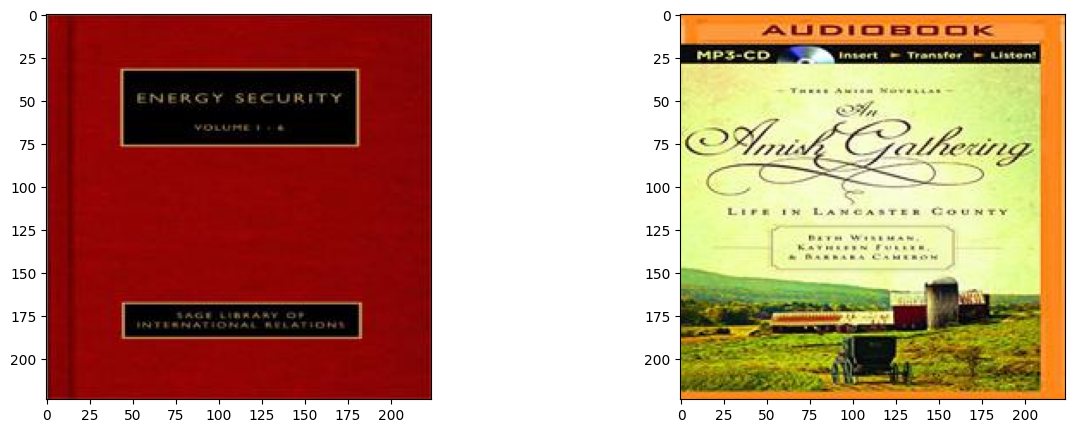

In [183]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Image.open("../raw_data/Images/1446276082.jpg"))
plt.subplot(1,2,2)
plt.imshow(Image.open("../raw_data/Images/1491522666.jpg"))

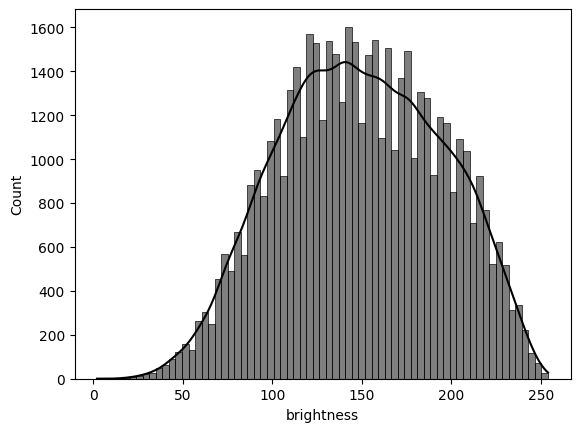

In [201]:
sns.histplot(df_train['brightness'], kde=True, color='black');

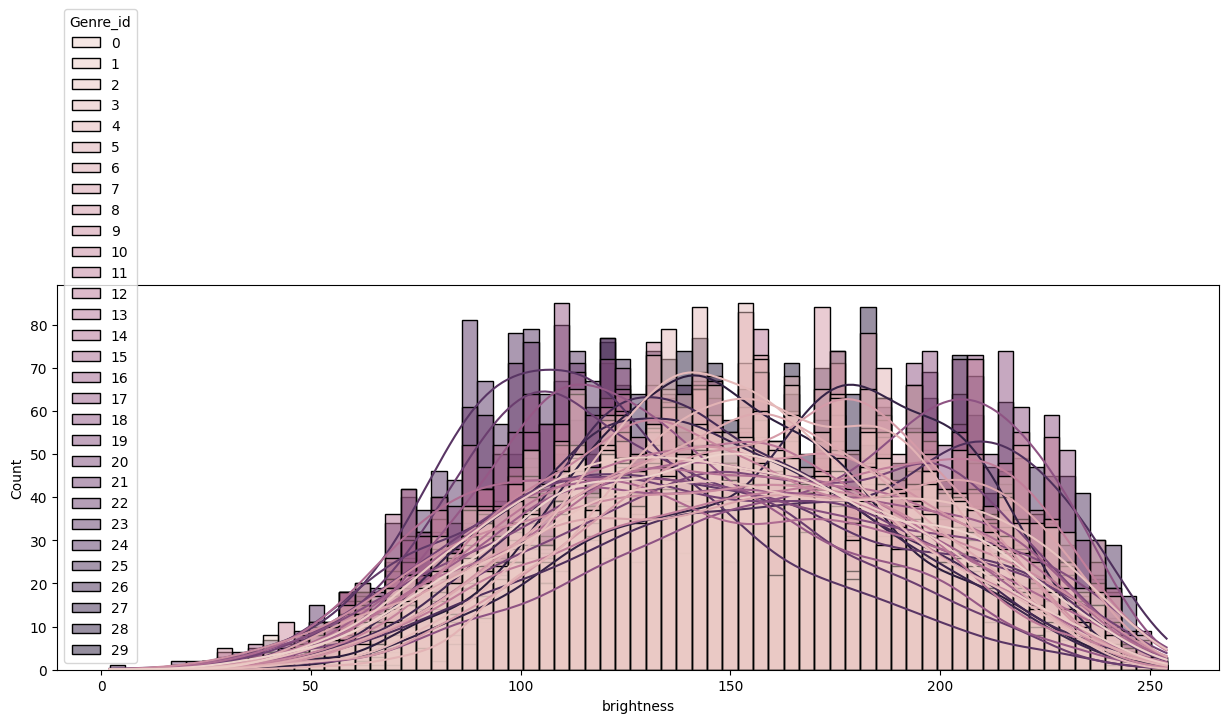

In [299]:
plt.figure(figsize=(15,5))
sns.histplot(data= df_train, x='brightness', kde=True, hue='Genre_id');

## Face recognition

In [17]:
def nb_faces_detected(im_file):
    img = cv2.imread(im_file)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    face = face_classifier.detectMultiScale(gray_image)
    return len(face)

In [186]:
df_train['nb_faces_detected'] = df_train['Image_name'].apply(lambda x: nb_faces_detected(f"../raw_data/Images/{x}"))

In [187]:
df_train.head(10)

,Image_name,Title,Genre_id,Genre_name,brightness,nb_faces_detected
Id,,,,,,
0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,1,Biographies & Memoirs,158,0
1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",4,Children's Books,159,0
2,1446276082.jpg,Energy Security (SAGE Library of International...,10,Engineering & Transportation,67,0
3,1491522666.jpg,An Amish Gathering: Life in Lancaster County,9,Christian Books & Bibles,195,0
4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...,26,Sports & Outdoors,140,0
5,8436808053.jpg,"Como vencer el insomnio. Tecnicas, reglas y co...",11,"Health, Fitness & Dieting",207,0
6,1848291388.jpg,John Martin Littlejohn: An Enigma of Osteopathy,16,Medical Books,112,1
7,0073402656.jpg,Chemistry: The Molecular Nature of Matter and ...,23,Science & Math,52,0
8,0323045979.jpg,Mosby's Oncology Nursing Advisor: A Comprehens...,16,Medical Books,125,0


In [190]:
df_train[df_train.nb_faces_detected == max(df_train.nb_faces_detected)].head()

,Image_name,Title,Genre_id,Genre_name,brightness,nb_faces_detected
Id,,,,,,
17649,1580650252.jpg,Hispanics in Hollywood,13,Humor & Entertainment,166,12


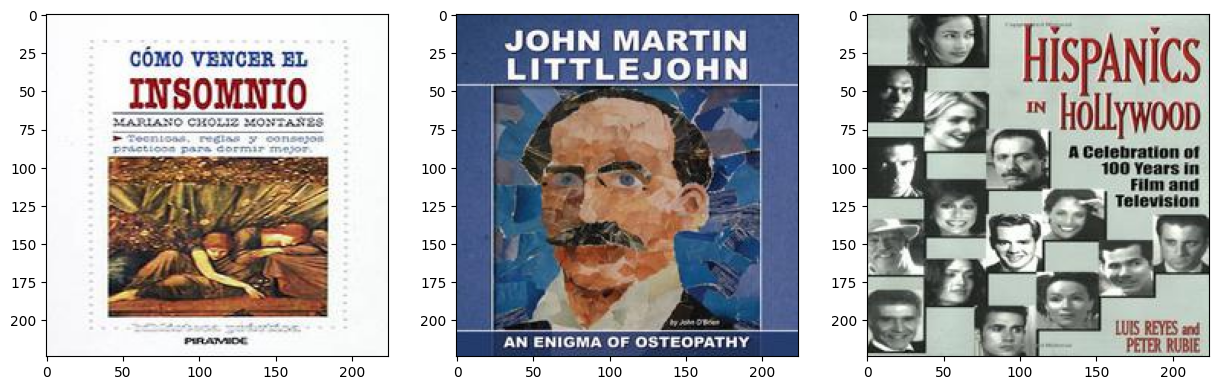

In [191]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(Image.open("../raw_data/Images/8436808053.jpg"))
plt.subplot(1,3,2)
plt.imshow(Image.open("../raw_data/Images/1848291388.jpg"))
plt.subplot(1,3,3)
plt.imshow(Image.open("../raw_data/Images/1580650252.jpg"))

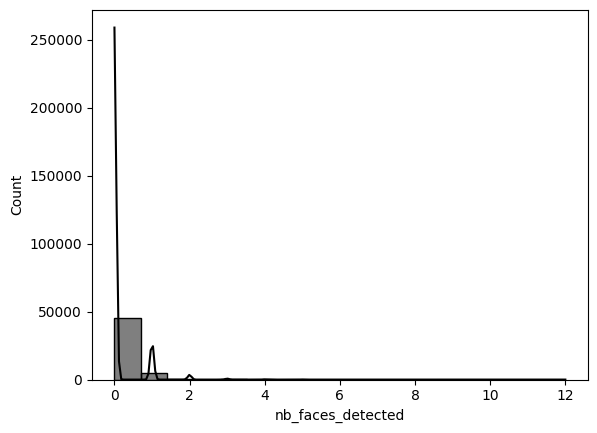

In [202]:
sns.histplot(df_train['nb_faces_detected'], kde=True, color='black');

In [192]:
df_train['face_detected'] = df_train['nb_faces_detected'].apply(lambda x: 1 if x>=1 else 0)

In [303]:
percent_face_detected = df_train.groupby('Genre_id').agg(percent_face_detected=('face_detected', 'mean'))

<AxesSubplot:xlabel='Genre_id', ylabel='percent_face_detected'>

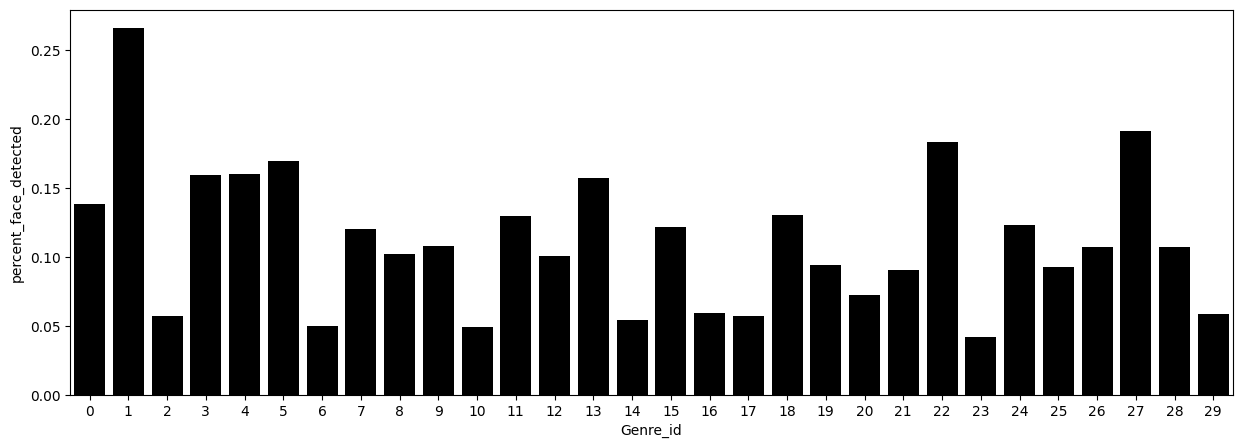

In [308]:
plt.figure(figsize=(15,5))
sns.barplot(y = percent_face_detected.percent_face_detected, x=percent_face_detected.index, color='black')

In [194]:
df_train.to_csv("../raw_data/df_train_picture_features.csv")

## Nb of colors

In [21]:
def nb_colors(im_file):
    img_temp = cv2.imread(im_file)
    N = img_temp.shape[0] * img_temp.shape[1]
    X = img_temp.reshape((N, 3))
    color_count = len(np.unique(X, axis=0))
    return color_count

In [197]:
df_train['nb_colors'] = df_train['Image_name'].apply(lambda x: nb_colors(f"../raw_data/Images/{x}"))

In [204]:
df_train.head()

,Image_name,Title,Genre_id,Genre_name,brightness,nb_faces_detected,face_detected,nb_colors
Id,,,,,,,,
0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,1,Biographies & Memoirs,158,0,0,7938
1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",4,Children's Books,159,0,0,20416
2,1446276082.jpg,Energy Security (SAGE Library of International...,10,Engineering & Transportation,67,0,0,4741
3,1491522666.jpg,An Amish Gathering: Life in Lancaster County,9,Christian Books & Bibles,195,0,0,27895
4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...,26,Sports & Outdoors,140,0,0,26154


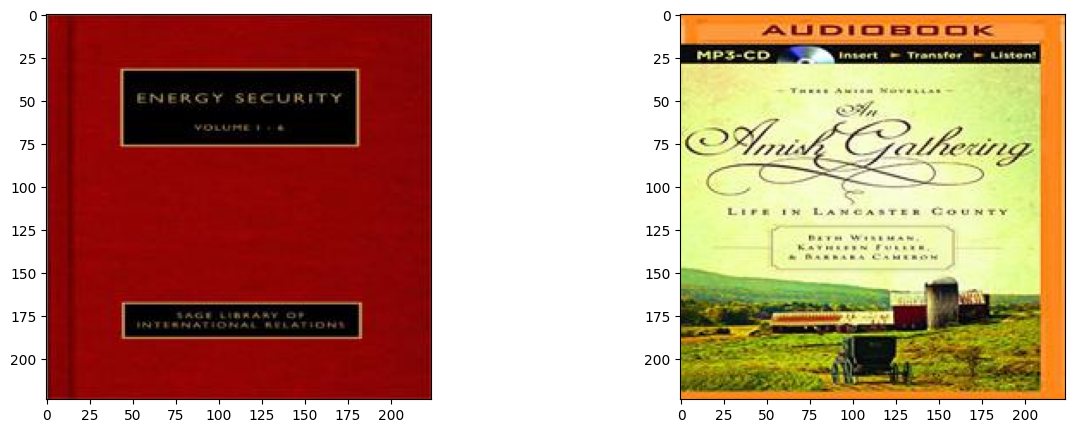

In [206]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Image.open("../raw_data/Images/1446276082.jpg"))
plt.subplot(1,2,2)
plt.imshow(Image.open("../raw_data/Images/1491522666.jpg"))

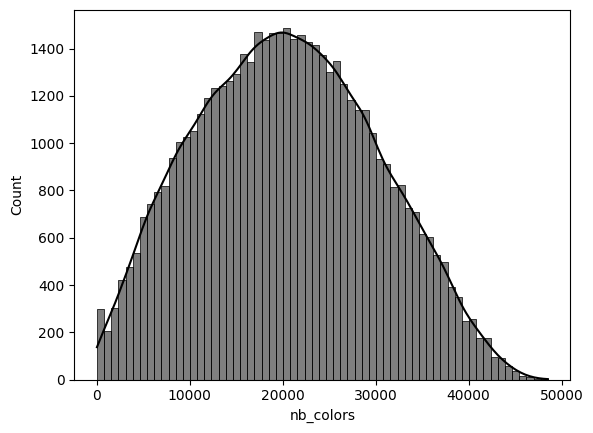

In [209]:
sns.histplot(df_train['nb_colors'], kde=True, color='black');

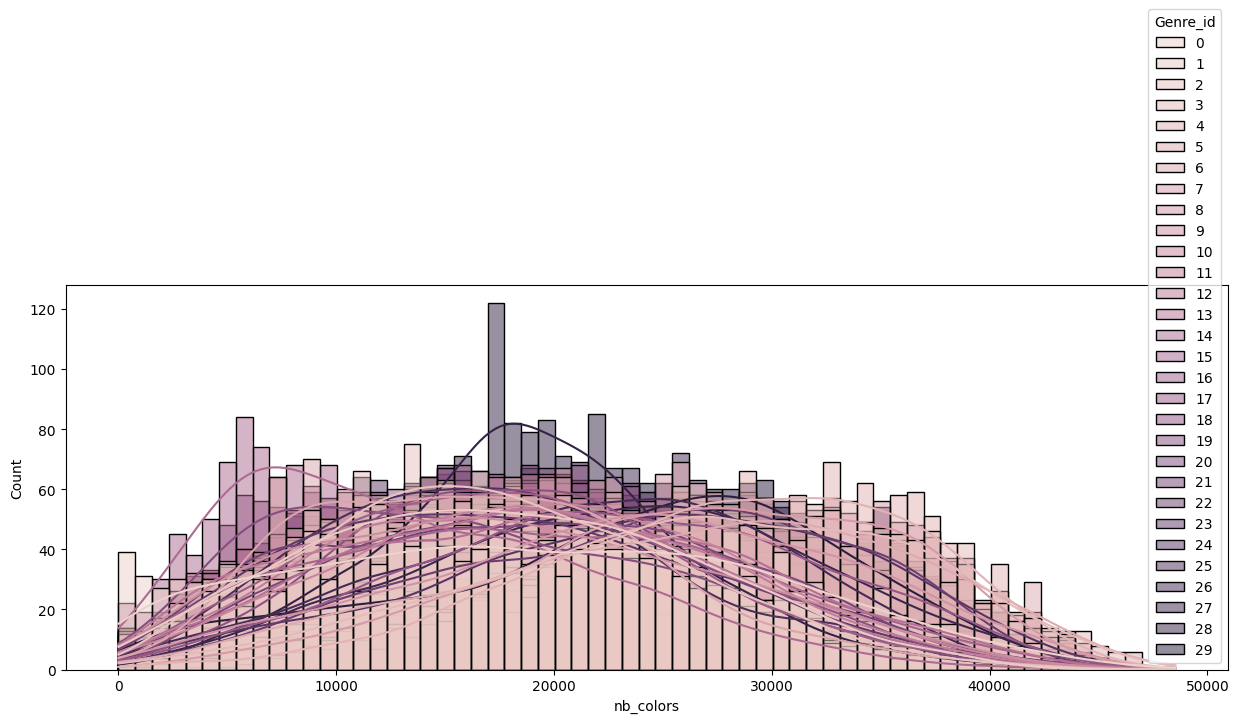

In [298]:
plt.figure(figsize=(15,5))
sns.histplot(data= df_train, x='nb_colors', kde=True, hue='Genre_id');

In [205]:
df_train.to_csv("../raw_data/df_train_picture_features.csv")

## Main colors hsl

### Extracting main colors

In [23]:
def main_colors_hex(im_file):
    color_thief = ColorThief(im_file)
    palette = color_thief.get_palette(color_count=3)
    palette_hex = [rgb2hex(int(i[0]), int(i[1]), int(i[2])) for i in palette]
    return palette_hex

In [227]:
df_train['main_colors_hex'] = df_train['Image_name'].apply(lambda x: main_colors_hex(f"../raw_data/Images/{x}"))

In [228]:
df_train.head()

,Id,Image_name,Title,Genre_id,Genre_name,brightness,nb_faces_detected,face_detected,nb_colors,main_colors_hex
0,0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,1,Biographies & Memoirs,158,0,0,7938,"[#5D604B, #DCD8C9, #B3B49E, #ACACAC]"
1,1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",4,Children's Books,159,0,0,20416,"[#6EAECE, #D26F28, #5E2624, #75754E]"
2,2,1446276082.jpg,Energy Security (SAGE Library of International...,10,Engineering & Transportation,67,0,0,4741,"[#8E0505, #0A0707, #AB7E6B, #534339]"
3,3,1491522666.jpg,An Amish Gathering: Life in Lancaster County,9,Christian Books & Bibles,195,0,0,27895,"[#E4EBA0, #383716, #CB8F1F, #8E5918]"
4,4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...,26,Sports & Outdoors,140,0,0,26154,"[#738FBD, #41443C, #CCD3B0, #2C386A]"


In [229]:
df_train.to_csv("../raw_data/df_train_picture_features.csv")

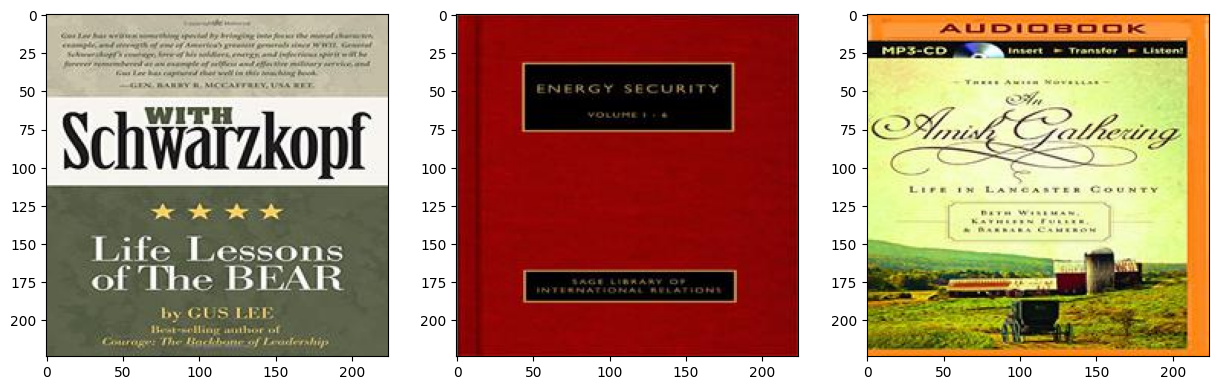

In [230]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(Image.open("../raw_data/Images/1588345297.jpg"))
plt.subplot(1,3,2)
plt.imshow(Image.open("../raw_data/Images/1446276082.jpg"))
plt.subplot(1,3,3)
plt.imshow(Image.open("../raw_data/Images/1491522666.jpg"))

In [236]:
display(Markdown('<br>'.join(
        f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
        for color in df_train[df_train.Image_name == '1588345297.jpg']['main_colors_hex'].to_list()[0]
    )))

<span style="font-family: monospace">#5D604B <span style="color: #5D604B">████████</span></span><br><span style="font-family: monospace">#DCD8C9 <span style="color: #DCD8C9">████████</span></span><br><span style="font-family: monospace">#B3B49E <span style="color: #B3B49E">████████</span></span><br><span style="font-family: monospace">#ACACAC <span style="color: #ACACAC">████████</span></span>

In [238]:
display(Markdown('<br>'.join(
        f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
        for color in df_copy[df_copy.Image_name == '1446276082.jpg']['main_colors_hex'].to_list()[0]
    )))

<span style="font-family: monospace">#8E0505 <span style="color: #8E0505">████████</span></span><br><span style="font-family: monospace">#0A0707 <span style="color: #0A0707">████████</span></span><br><span style="font-family: monospace">#AB7E6B <span style="color: #AB7E6B">████████</span></span><br><span style="font-family: monospace">#534339 <span style="color: #534339">████████</span></span>

In [239]:
display(Markdown('<br>'.join(
        f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
        for color in df_copy[df_copy.Image_name == '1491522666.jpg']['main_colors_hex'].to_list()[0]
    )))

<span style="font-family: monospace">#E4EBA0 <span style="color: #E4EBA0">████████</span></span><br><span style="font-family: monospace">#383716 <span style="color: #383716">████████</span></span><br><span style="font-family: monospace">#CB8F1F <span style="color: #CB8F1F">████████</span></span><br><span style="font-family: monospace">#8E5918 <span style="color: #8E5918">████████</span></span>

### Hex to rgb to hsl

In [27]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    return tuple(int(value[i:i+2], 16) for i in (0, 2 ,4))

In [241]:
df_train['main_colors_rgb'] = df_train['main_colors_hex'].apply(lambda x: [hex_to_rgb(i) for i in x])
df_train['main_colors_hls'] = df_train['main_colors_rgb'].apply(lambda x: [colorsys.rgb_to_hls(i[0]/255, i[1]/255, i[2]/255) for i in x])

In [242]:
df_train.head()

,Id,Image_name,Title,Genre_id,Genre_name,brightness,nb_faces_detected,face_detected,nb_colors,main_colors_hex,main_colors_rgb,main_colors_hls
0,0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,1,Biographies & Memoirs,158,0,0,7938,"[#5D604B, #DCD8C9, #B3B49E, #ACACAC]","[(93, 96, 75), (220, 216, 201), (179, 180, 158...","[(0.19047619047619055, 0.33529411764705885, 0...."
1,1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",4,Children's Books,159,0,0,20416,"[#6EAECE, #D26F28, #5E2624, #75754E]","[(110, 174, 206), (210, 111, 40), (94, 38, 36)...","[(0.5555555555555555, 0.6196078431372549, 0.49..."
2,2,1446276082.jpg,Energy Security (SAGE Library of International...,10,Engineering & Transportation,67,0,0,4741,"[#8E0505, #0A0707, #AB7E6B, #534339]","[(142, 5, 5), (10, 7, 7), (171, 126, 107), (83...","[(0.0, 0.2882352941176471, 0.9319727891156461)..."
3,3,1491522666.jpg,An Amish Gathering: Life in Lancaster County,9,Christian Books & Bibles,195,0,0,27895,"[#E4EBA0, #383716, #CB8F1F, #8E5918]","[(228, 235, 160), (56, 55, 22), (203, 143, 31)...","[(0.18222222222222215, 0.7745098039215685, 0.6..."
4,4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...,26,Sports & Outdoors,140,0,0,26154,"[#738FBD, #41443C, #CCD3B0, #2C386A]","[(115, 143, 189), (65, 68, 60), (204, 211, 176...","[(0.6036036036036037, 0.596078431372549, 0.359..."


In [243]:
df_train.main_colors_hls[0]

[(0.19047619047619055, 0.33529411764705885, 0.12280701754385961),
 (0.13157894736842096, 0.8254901960784313, 0.21348314606741586),
 (0.17424242424242445, 0.6627450980392158, 0.1279069767441861),
 (0.0, 0.6745098039215687, 0.0)]

In [244]:
df_train.to_csv("../raw_data/df_train_picture_features.csv")

### Extracting hue, lightness, saturation

In [278]:
df_train.head()

,Id,Image_name,Title,Genre_id,Genre_name,brightness,nb_faces_detected,face_detected,nb_colors,main_colors_hex,main_colors_rgb,main_colors_hls
0,0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,1,Biographies & Memoirs,158,0,0,7938,"['#5D604B', '#DCD8C9', '#B3B49E', '#ACACAC']","[(93, 96, 75), (220, 216, 201), (179, 180, 158...","[(0.19047619047619055, 0.33529411764705885, 0...."
1,1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",4,Children's Books,159,0,0,20416,"['#6EAECE', '#D26F28', '#5E2624', '#75754E']","[(110, 174, 206), (210, 111, 40), (94, 38, 36)...","[(0.5555555555555555, 0.6196078431372549, 0.49..."
2,2,1446276082.jpg,Energy Security (SAGE Library of International...,10,Engineering & Transportation,67,0,0,4741,"['#8E0505', '#0A0707', '#AB7E6B', '#534339']","[(142, 5, 5), (10, 7, 7), (171, 126, 107), (83...","[(0.0, 0.2882352941176471, 0.9319727891156461)..."
3,3,1491522666.jpg,An Amish Gathering: Life in Lancaster County,9,Christian Books & Bibles,195,0,0,27895,"['#E4EBA0', '#383716', '#CB8F1F', '#8E5918']","[(228, 235, 160), (56, 55, 22), (203, 143, 31)...","[(0.18222222222222215, 0.7745098039215685, 0.6..."
4,4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...,26,Sports & Outdoors,140,0,0,26154,"['#738FBD', '#41443C', '#CCD3B0', '#2C386A']","[(115, 143, 189), (65, 68, 60), (204, 211, 176...","[(0.6036036036036037, 0.596078431372549, 0.359..."


In [280]:
df_train['hues'] = df_train['main_colors_hls'].apply(lambda x: [i[0] for i in x])
df_train['lightnesses'] = df_train['main_colors_hls'].apply(lambda x: [i[1] for i in x])
df_train['saturations'] = df_train['main_colors_hls'].apply(lambda x: [i[2] for i in x])

In [281]:
df_train['hue_1'] = df_train['hues'].apply(lambda x: int(x[0]* 360))
df_train['hue_2'] = df_train['hues'].apply(lambda x: int(x[1]* 360))
df_train['hue_3'] = df_train['hues'].apply(lambda x: int(x[2]* 360))
df_train['hue_4'] = df_train['hues'].apply(lambda x: int(x[3]* 360))

In [282]:
df_train['lightness_1'] = df_train['lightnesses'].apply(lambda x: round(x[0], 3))
df_train['lightness_2'] = df_train['lightnesses'].apply(lambda x: round(x[1], 3))
df_train['lightness_3'] = df_train['lightnesses'].apply(lambda x: round(x[2], 3))
df_train['lightness_4'] = df_train['lightnesses'].apply(lambda x: round(x[3], 3))

In [283]:
df_train['saturation_1'] = df_train['saturations'].apply(lambda x: round(x[0], 3))
df_train['saturation_2'] = df_train['saturations'].apply(lambda x: round(x[1], 3))
df_train['saturation_3'] = df_train['saturations'].apply(lambda x: round(x[2], 3))
df_train['saturation_4'] = df_train['saturations'].apply(lambda x: round(x[3], 3))

In [285]:
df_train.to_csv("../raw_data/df_train_picture_features.csv")

In [293]:
df_train.columns

Index(['Id', 'Image_name', 'Title', 'Genre_id', 'Genre_name', 'brightness',
       'nb_faces_detected', 'face_detected', 'nb_colors', 'main_colors_hex',
       'main_colors_rgb', 'main_colors_hls', 'hues', 'lightnesses',
       'saturations', 'hue_1', 'hue_2', 'hue_3', 'hue_4', 'lightness_1',
       'lightness_2', 'lightness_3', 'lightness_4', 'saturation_1',
       'saturation_2', 'saturation_3', 'saturation_4'],
      dtype='object')

# Preprocessing features extracted

In [158]:
df_train = pd.read_csv("../raw_data/df_train_picture_features.csv", index_col=0)
df_test = pd.read_csv("../raw_data/df_test_picture_features.csv", index_col=0)

In [160]:
mm_scaler = MinMaxScaler() 
df_train[['brightness', 'nb_colors']] = mm_scaler.fit_transform(df_train[['brightness', 'nb_colors']])
df_test[['brightness', 'nb_colors']] = mm_scaler.transform(df_test[['brightness', 'nb_colors']])

In [161]:
df_train['hue_1_sin'] = np.sin(2*np.pi*df_train.hue_1/360)
df_train['hue_1_cos'] = np.cos(2*np.pi*df_train.hue_1/360)

df_test['hue_1_sin'] = np.sin(2*np.pi*df_test.hue_1/360)
df_test['hue_1_cos'] = np.cos(2*np.pi*df_test.hue_1/360)

In [162]:
df_train_pp = df_train[['brightness', 'nb_colors', 'hue_1_sin', 'hue_1_cos', 'lightness_1', 'saturation_1', 'face_detected']]
df_train_pp.to_csv("../raw_data/X_train_picture_features_pp.csv")

df_test_pp = df_test[['brightness', 'nb_colors', 'hue_1_sin', 'hue_1_cos', 'lightness_1', 'saturation_1', 'face_detected']]
df_test_pp.to_csv("../raw_data/X_test_picture_features_pp.csv")

# Models

## Logistic regression

In [163]:
X_train_picture_features_pp = pd.read_csv("../raw_data/X_train_picture_features_pp.csv", index_col=0)
X_test_picture_features_pp = pd.read_csv("../raw_data/X_test_picture_features_pp.csv", index_col=0)

In [164]:
y_train = pd.read_csv("../raw_data/train_y.csv", delimiter=" ", index_col="Id")
y_train = y_train['Genre_id']

y_test = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")
y_test = y_test['Genre_id']

In [165]:
logr = LogisticRegression()

cv_results = cross_validate(logr,
                            X_train_picture_features_pp,
                            y_train, 
                            cv=5, 
                            scoring=['accuracy'])

pd.DataFrame(cv_results)[['test_accuracy']].mean()

test_accuracy    0.089903
dtype: float64

In [166]:
logr_model = logr.fit(X_train_picture_features_pp, y_train)

In [167]:
permutation_score = permutation_importance(logr_model, X_train_picture_features_pp, y_train, n_repeats=10) 
importance_df = pd.DataFrame(np.vstack((X_train_picture_features_pp.columns, permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']
importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
1,nb_colors,0.027628
0,brightness,0.020725
3,hue_1_cos,0.007747
4,lightness_1,0.007257
5,saturation_1,0.006407
6,face_detected,0.00554
2,hue_1_sin,0.00229


In [168]:
y_test_pred_logr = logr_model.predict(X_test_picture_features_pp)

In [169]:
accuracy_logr_model = accuracy_score(y_test, y_test_pred_logr)
print(f'Accuracy Logistic Regression model: {accuracy_logr_model*100:.2f}%')

Accuracy Logistic Regression model: 9.09%


## Linear SVC

In [197]:
svc_rbf = SVC(kernel='rbf', C=0.5, gamma=20)
svc_model = svc_rbf.fit(X_train_picture_features_pp, y_train)

In [198]:
y_test_pred_svc = svc_model.predict(X_test_picture_features_pp)

In [199]:
accuracy_linear_svc_model = accuracy_score(y_test, y_test_pred_svc)
print(f'Accuracy Linear SVC model: {accuracy_linear_svc_model*100:.2f}%')

Accuracy Linear SVC model: 10.72%


# Old code in case

## Face recognition other library

In [42]:
import face_recognition

In [45]:
image = face_recognition.load_image_file("../raw_data/Images/0002553899.jpg")
face_locations = face_recognition.face_locations(image)
face_locations

[(63, 179, 138, 104)]